Andreu Gimenez Bolinches ([andreu@keio.jp](mailto:andreu@keio.jp))

This report has been written using an interactive Python notebook, which has
been then converted into `pdf`. One can find the source notebook in
the [code
repository](https://gitlab.com/jemaro/keio/ad-hoc-sensor-network/kalman-filter).
The code shown here has been developed prioritizing readability and the
application of the concepts explained during the lectures.

Initially we will import some general libraries.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.typing import ArrayLike
from numpy import sin, cos, tan, pi, exp
from typing import Callable, Optional, Tuple
from matplotlib import rcParams

rcParams['text.usetex'] = True
rcParams['figure.figsize'] = [10.0, 6.0]

# Kalman Filter

The Kalman Filter has been implemented as a Python object. It can receive as
input the initial state $X_0$ and covariance $P_0$; the state space system $A$
and control $B$ matrices; the measurement $H$, measurement noise covariance $R$
and process noise covariance $Q$. These initialization values are used in the
filter methods `predict` and `correct` which modify the `object` data, i.e. the
state `X` and error covariance `P` matrices. The former uses the control input
$u$ in order to project the state and its error covariance ahead, the later
uses the measurement $z$ and the computed property `K` corresponding to the
_Kalman Gain_ in order to correct these a priori estimations.

A filter update iteration is composed by one `predict` and one `correct` step.
The method `_update` takes care of receiving a single control command $u$ and
its corresponding measurement $z$ in order to realize a single update
iteration. The method `update` can take as input several consecutive control
commands $u$ and their corresponding measurements $z$. It iterates over them to
update the filter and returns the state $X$ and error covariance $P$ at each
step.

The default initialization values correspond to a random constant ($A = 1$) and
uncontrolled ($B = 0$) system with just one state ($n = 1$) directly measured
($H = 1$); The state value $X_0$ is initialized by default to $0$ and the state
covariance $P_0$ to $1$. Process noise $Q$ and measurement noise $R$ matrices
are initialized by default to $1$ but the simulations will override the default
values.

The object initialization and `update` method test the input variables in order
to check that the input has the apropiate dimensions, raising an informative
error if it is not the case.

In [2]:
class KalmanFilter:
    def __init__(
            self,
            X0: ArrayLike = np.zeros((1, 1)),
            P0: ArrayLike = np.eye(1, 1),
            A: ArrayLike = np.eye(1, 1),
            B: ArrayLike = np.zeros((1, 1)),
            Q: ArrayLike = np.eye(1, 1),
            H: ArrayLike = np.eye(1, 1),
            R: ArrayLike = np.eye(1, 1),
        ):
        # State mean
        self.X = np.atleast_2d(X0)  # nx1 State matrix
        assert self.X.shape[1] == 1, f'X0: {self.X.shape}≠(n,1)'
        self.n = n = self.X.shape[0]  # State dimension
        self.A = np.atleast_2d(A)  # nxn State transition matrix
        assert self.A.shape == (n, n), f'A: {self.A.shape}≠{(n,n)}'
        self.B = np.atleast_2d(B)  # nxl Control matrix
        assert self.B.shape[0] == n, f'B: {self.B.shape}≠({n},l)'
        self.l = self.B.shape[1]  # Control dimension
        # State variance
        self.P = np.atleast_2d(P0)  # nxn Covariance matrix
        assert self.P.shape == (n, n), f'P0: {self.P.shape}≠{(n,n)}'
        self.Q = np.atleast_2d(Q)  # nx1 Process noise covariance
        assert self.Q.shape == (n, 1), f'Q: {self.Q.shape}≠{(n,1)}'
        self.H = np.atleast_2d(H)  # mxn Measurement matrix
        assert self.H.shape[1] == n, f'H: {self.H.shape}≠(m,{n})'
        self.m = m = H.shape[0]  # Measurement dimension
        self.R = np.atleast_2d(R)  # mxm Estimated measurement noise covariance
        assert self.R.shape == (m, n), f'R: {self.R.shape}≠{(m,n)}'

    def predict(
            self,
            u: ArrayLike = np.zeros(1),  # lx1 Control vector
        ):
        # Project the state ahead
        self.X = X = self.A @ self.X + self.B @ u
        # Project the error covariance ahead
        self.P = P = self.A @ self.P @ self.A.T + self.Q
        return X, P

    @property
    def K(self):  # Kalman gain
        return self.P @ self.H.T @ \
            np.linalg.pinv(self.H @ self.P @ self.H.T + self.R) #Pseudo inverse

    def correct(
            self,
            z: ArrayLike,  # mx1 Measurement vector
        ):
        # Compute the Kalman gain
        K = self.K
        # Update the state estimate with the measurement "z"
        self.X = X = self.X + K @ (z - self.H @ self.X)
        # Update the error covariance
        self.P = P = (np.eye(self.P.shape[0]) - K @ self.H) @ self.P
        return X, P

    def _update(
            self,
            z: ArrayLike,  # mx1 Measurement vector
            u: Optional[ArrayLike] = None,  # lx1 Control vector
        ):
        # Predict and correct a single measurement "z" corresponding to a
        # single control input "u"
        if u is not None:
            u = np.zeros((self.l, 1))
        self.predict(u)
        return self.correct(z)

    def update(
            self,
            z: ArrayLike,  # mxk Measurement vectors
            u: Optional[ArrayLike] = None,  # lxk Control vectors
        ):
        # Update the state and its error covariance iterating over the
        # measurements "z" and their corresponding to a control inputs "u"
        m, k = z.shape
        assert m == self.m, f'z: {z.shape}≠({self.m},k)'
        if u is None: # If no control input is given, assume no control input
            u = np.zeros((self.l, k))
        else: # Otherwise, check the dimensions
            assert u.shape == (self.l, k), f'u: {u.shape}≠{(self.m,k)}'
        # Iterate over the measurements and their corresponding control inputs
        X, P = zip(
            *(self._update(zk, uk) for zk, uk in np.stack((z.T, u.T), axis=1))
            )
        return np.column_stack(X), np.column_stack(P)

# Simulation tool

The Kalman Filter implemented above has a handy method `update` that will take
care of the simulation backend. Nevertheless the function needs some generated
measurements $z$ and the results should be visualized.

## Noisy measurements

The function `measure` generates different noisy measurements of $f(t)$ over the
time vector `t` with a gaussian variance given by `sigma2` ($\sigma^2$). It
allows to reproduce the same random noise by setting the random seed and it can
return the noiseless measurements $x = f(t)$ as well.

In [3]:
def measure(
    f: Callable,
    t: ArrayLike = np.linspace(0, 1, 100),
    sigma2: ArrayLike = 0,  # Measurement noise covariance
    random_seed: Optional[int] = None,  # Allow for reproducibility
    return_x: bool = False,  # Return noiseless measurements too
    ) -> Tuple[ArrayLike, ArrayLike, Optional[ArrayLike]]:
    # Generate noisy measurements from a given function "f"
    t = np.atleast_2d(t)
    x = np.vectorize(f)(t)
    if random_seed is not None: # Set a seed for reproducibility
        np.random.seed(random_seed)
    if return_x: # Return noiseless measurements too
        return t, x + np.random.randn(*t.shape) * sigma2, x
    return t, x + np.random.randn(*t.shape) * sigma2

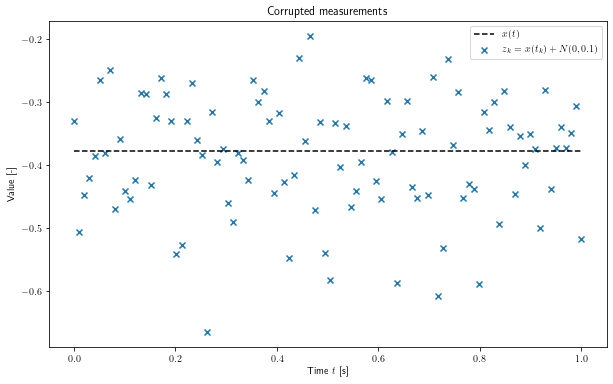

In [4]:
# Plot the noisy measurements
_, ax = plt.subplots(1, 1)
sigma2 = 0.1
t, z, x = measure(lambda t: -0.37727, sigma2=sigma2, return_x=True)
ax.scatter(
    t[0, :], z[0, :], marker='x', label=f'$z_k = x(t_k) + N(0,{sigma2})$'
    )
ax.plot(t[0, :], x[0, :], 'k--', label='$x(t)$')
ax.set_title('Corrupted measurements')
ax.set_ylabel('Value [-]')
ax.set_xlabel('Time $t$ [s]')
_ = ax.legend()

## Plot

With the current implementation one can get simulation results with only a few
lines of setup. However, the visualization of these results are significantly
longer to setup in terms of code. The function `plot_randvar_kalman` takes as
input a string that defines the observed random function `x_t`, the measurement
noise covariance that will be used in the Kalman Filter `R_est` and the real
measurement noise covariance `R_real` that will be used to generate the noisy
measurements of the observed function `x_t`; The process noise covariance `Q`
used in the Kalman Filter; the `duration` of the simulation and the `timestep`
between measurements; lastly, a parameter that allows to reproduce the same
random noise `random_seed` and some plot axes `ax_X` and `ax_P` where to plot
the filtered mean and covariance evolution over time, respectively.

In [5]:
def plot_randvar_kalman(
    x_t: str,  # Observed function
    R_est: float,  # Estimated measurement noise covariance
    R_real: float = 0.1,  # Real measurement noise covariance
    Q: float = 1e-6,  # Process noise covariance
    duration: float = 1,
    timestep: float = 0.02,
    random_seed: int = 0,
    ax_X: Optional[plt.Axes] = None,
    ax_P: Optional[plt.Axes] = None,
    ):
    # If no axes are given, create them
    if ax_X is None and ax_P is None:
        _, (ax_X, ax_P) = plt.subplots(1, 2, figsize=(12, 4))
    # Initialize Kalman filter
    kalman = KalmanFilter(Q=Q, R=R_est)
    # Create measurements over time
    t = np.arange(0, duration, timestep)
    try:
        f = eval('lambda t: ' + x_t)
        t, z, x = measure(f, t, R_real, return_x=True, random_seed=random_seed)
        print()  # Clear the output
    except Exception as e:
        print(str(e))
        return  # Don't plot if the expression is invalid
    # Update the filter with all the measuremetns
    X, P = kalman.update(z)
    # Plot the mean with error bars
    if ax_X is not None:
        ax_X.clear()
        ax_X.scatter(
            t[0, :],
            z[0, :],
            marker='x',
            label=f'$z_k = x(t_k) + N(0,{R_real})$'
            )
        y_lims = ax_X.get_ylim()
        ax_X.plot(t[0, :], x[0, :], 'k--', label='$x(t)=$ '+x_t)
        ax_X.plot(t[0, :], X[0, :], 'r-', label=f'$\mu_k$')
        ax_X.fill_between(
            t[0, :],
            X[0, :] - 2 * np.sqrt(P[0, :]),
            X[0, :] + 2 * np.sqrt(P[0, :]),
            color='r',
            alpha=0.2,
            label='$\mu_k \pm 2\sigma_k$',
            )
        ax_X.set_ylim(y_lims)
        ax_X.set_title(f'Kalman Filter: $R={R_est} \quad Q={Q}$', pad=25)
        ax_X.set_ylabel('Value [-]')
        ax_X.set_xlabel('Time $t$ [s]')
        handles, labels = ax_X.get_legend_handles_labels()
        order = [0, 2, 1, 3]
        ax_X.legend(
            [handles[idx] for idx in order],
            [labels[idx] for idx in order],
            loc='upper center',
            bbox_to_anchor=(0.5, 1.1),
            ncol=4,
            columnspacing=0.5,
            fancybox=True,
            shadow=True,
            )
    # Plot the error covariance
    if ax_P is not None:
        ax_P.clear()
        ax_P.plot(t[0, :], P[0, :], 'r-')
        ax_P.set_title(f'Kalman Filter: $R={R_est} \quad Q={Q}$', pad=25)
        ax_P.set_ylabel('Error Covariance ahead $P_k$')
        ax_P.set_xlabel('Time $t$ [s]')

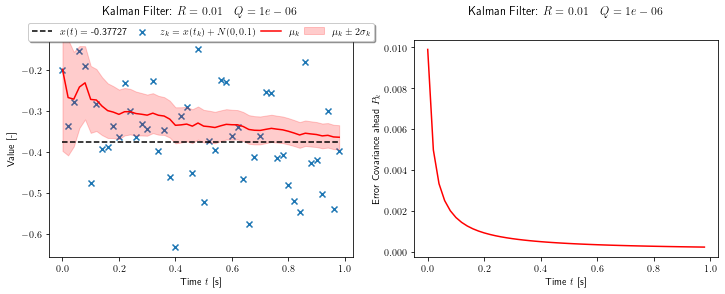

In [6]:
plot_randvar_kalman(x_t='-0.37727', R_est=0.01)

## Interactive tool

The plot function implemented above can visualize different simulation results
with just one line of code. But it is also very useful to have an interactive
tool which allows the modification of the parameters easily with on-screen
controls. Thanks to the nature of Python notebooks it doesn't take many lines
to set up said interactive tool.

In [ ]:
%matplotlib widget

In [ ]:
from ipywidgets import interact, fixed, FloatLogSlider, FloatSlider
from functools import partial

_, ax = plt.subplots(1, 1)
MyLogSlider = partial(FloatLogSlider, base=10, min=-10, max=1, step=1)

controls = {
    'Q':
        MyLogSlider(value=1e-6, description='Q'),
    'R_est':
        MyLogSlider(value=0.01, description='R'),
    'R_real':
        MyLogSlider(value=0.1, description='sigma^2'),
    'timestep':
        FloatSlider(
            value=0.02, min=0.001, max=0.1, step=0.001, readout_format='.3f'
            ),
    }

_ = interact(
    plot_randvar_kalman,
    x_t='-0.37727',
    duration=(0.5, 10),
    random_seed=fixed(0),
    ax_X=fixed(ax),
    ax_P=fixed(None),
    **controls
    )


Unfortunately, interactive cells are not rendered in the report, clone the
[code
repository](https://gitlab.com/jemaro/keio/ad-hoc-sensor-network/kalman-filter)
in order to use it:

![interactive](images/interactive.jpg)

# Discussion

Implemented the Kalman Filter and the Simulation tool, it's the turn to use it
and discuss the findings.

## Estimated Measurement Covariance against the Real Measurement Covariance

The Kalman Filter can have a different estimation of the measurement noise than
the reality. In the following plots the real measurement noise covariance has
been kept to 0.1 while the Kalman Filter measurement noise covariance has been
altered from 1 to 0.000001.

When the estimated measurement noise is larger than the reality, the Kalman
Filter takes more time (measurements) in order to stabilize the state mean and
the state error covariance keeps being higher than the real measurement noise.
When the estimation is slightly lower or equal to the real measurement noise,
one can see that even if the state mean oscillates with the measurements, the
real value is almost always within the 95% confidence interval 
($\mu \pm 2*\sigma$). Finally, when the estimated measurement noise is
significantly lower than the real one, the Kalman Filter oscillates
significantly with the measurements, proving a poor filter behaviour.

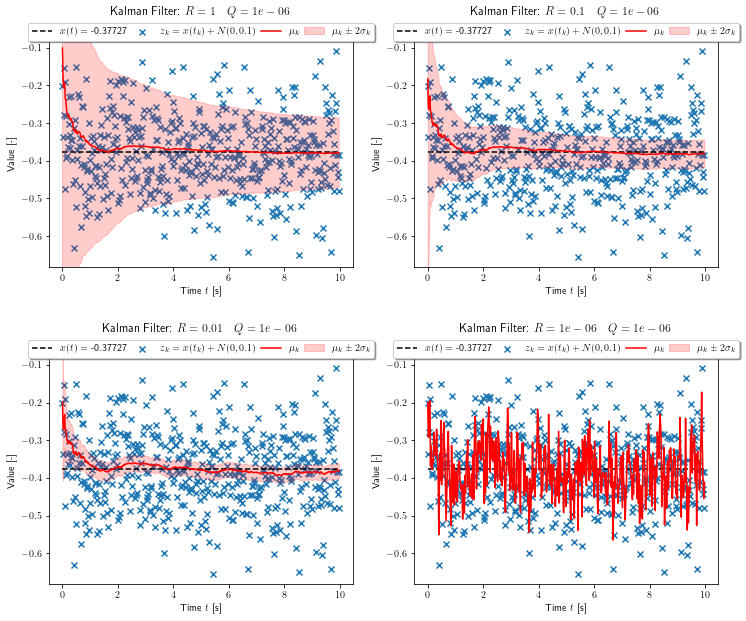

In [7]:
_, axes = plt.subplots(2, 2, figsize=(12, 10))
plt.subplots_adjust(hspace=0.4)
axes = [ax for row in axes for ax in row]
for i, R_est in enumerate([1, 0.1, 0.01, 1e-6]):
    plot_randvar_kalman(
        x_t='-0.37727',
        R_est=R_est,
        R_real=0.1,
        duration=10,
        timestep=0.02,
        random_seed=0,
        ax_X=axes[i]
        )

## Estimated variable not constant

Below are illustrated the results of a Constant Variable Kalman Filter when
applied to data that does not correspond to noisy measurements of a constant
variable. It is clear that the application of this filter in this situation is
suboptimal and needs to be carefully tuned in order to balance the dynamic and
static properties. The filter results lag behind the real measurements if the
estimated measurement noise (the Kalman Filter distrust in measurements) is not
sufficiently low, but if it is too low then the filter will not overcome the
random noise as it has been discussed above.

This lag in oscillating measurements can result in a reduced oscillation
amplitude from the Kalman Filter output.

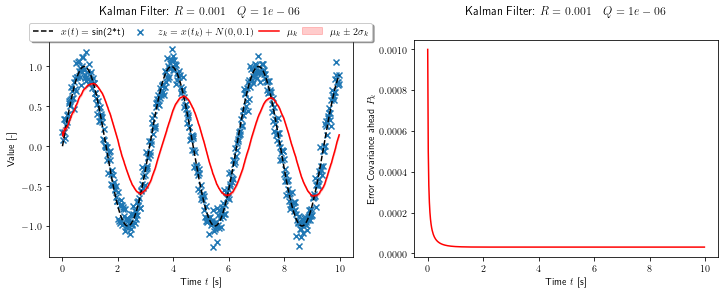

In [8]:
plot_randvar_kalman(x_t='sin(2*t)', R_est=0.001, duration=10, random_seed=0)

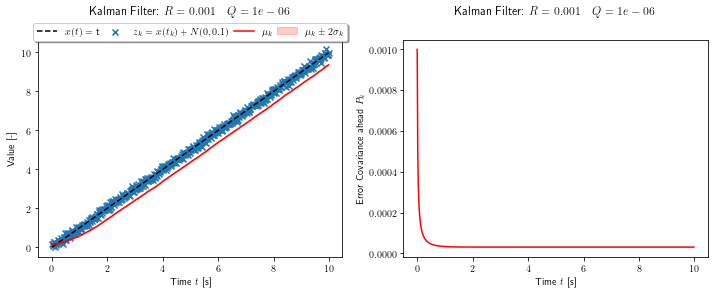

In [9]:
plot_randvar_kalman(x_t='t', R_est=0.001, duration=10, random_seed=0)

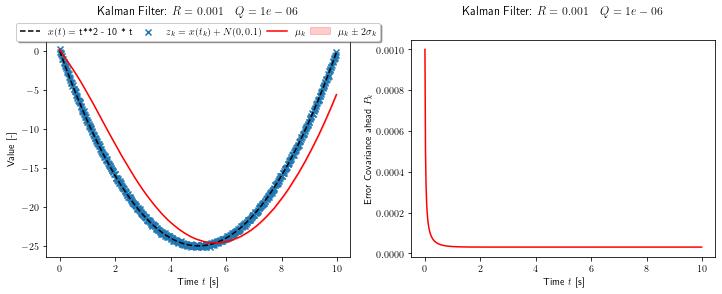

In [10]:
plot_randvar_kalman(x_t='t**2 - 10 * t', R_est=0.001, duration=10, random_seed=0)

In [11]:
plot_randvar_kalman(x_t='exp(t)', R_est=0.001, duration=5, random_seed=0)

## Effect of the process noise

The process in the Constant Variable Kalman Filter is to keep the state as it is
($A = 1$), therefore the process noise affects directly to the state error
covariance. Large process noises will not allow the state error covariance to
converge in a sufficiently low value.

In [12]:
_, axes = plt.subplots(2, 2, figsize=(12, 10))
plt.subplots_adjust(hspace=0.4)
for i, Q in enumerate([1e-3, 1e-6]):
    plot_randvar_kalman(
        x_t='-0.37727',
        R_est=0.01,
        Q=Q,
        duration=10,
        timestep=0.02,
        random_seed=0,
        ax_X=axes[i][0],
        ax_P=axes[i][1],
        )

## Various sets of measurements

Finally, the following plots illustrate the same Kalman Filter handling
different sets of noisy measurements of the same constant value. One can see
that if tuned properly, the Kalman Filter is able to overcome the randomness,
providing robust state mean and error.

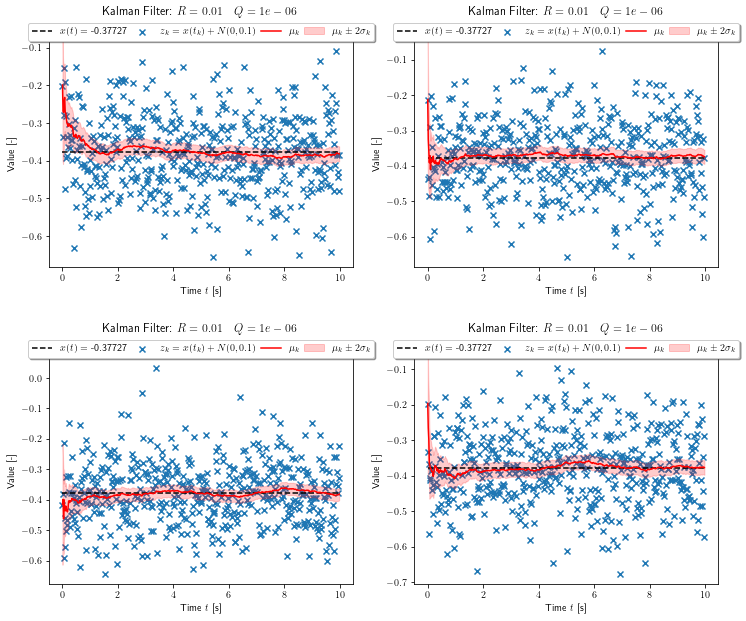

In [13]:
_, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = [ax for row in axes for ax in row]
plt.subplots_adjust(hspace=0.4)
for i in range(4):
    plot_randvar_kalman(
        x_t='-0.37727',
        R_est=0.01,
        duration=10,
        timestep=0.02,
        random_seed=i,
        ax_X=axes[i],
        )